In [1]:
%run gl_functions.ipynb
%run spot_functions.ipynb

In [2]:
# sdk, robot, id_client, \
# robot_state_client, command_client, \
# image_client, graph_nav_client, \
# world_object_client, manipulation_api_client = initRobot('192.168.50.3')
# timeout_sec = 10

In [3]:
# lease_client, lease, lease_keep_alive = getLease(robot)

In [185]:
moveRobotRelative(command_client, -0.5, 0, 0)

In [37]:
timeout_sec = 15

In [4]:
# Initialize Groundlight API

GROUNDLIGHT_API_TOKEN = 'api_2Au8NPiTMbSLQ73Vjr2eMhX2qUh_pt4EEKhtDNgnjN3dUAr89YANDcYsmBkJZV'
gl = Groundlight(api_token=GROUNDLIGHT_API_TOKEN)
detectors = gl.list_detectors()
canDet = detectors.results[0]

In [66]:
getBattInfo()

Battery at: 32.0 %. Robot has 1839 seconds left


(32.0, 1839)

In [4]:
success = powerOn(robot)

True


In [6]:
bdcrc.blocking_selfright(command_client, timeout_sec = 5)

In [51]:
def canSearch(command_client, image_client,):
    tree = None
    handColor = None

    for handPosInd in range(len(canSearchCamCoords)):

        cmd = RobotCommandBuilder.claw_gripper_open_fraction_command(1.0)
        cmd_id = command_client.robot_command(cmd, end_time_secs = time.time()+timeout_sec)

        moveToAndLookAt(command_client, 
                        canSearchCamCoords[handPosInd]['moveTo'], 
                        canSearchCamCoords[handPosInd]['lookAt'])
        time.sleep(0.3)

        handColorImg, image_response = capHandImage(image_client, 'hand_color_image')
        
        time.sleep(0.1)
        
        tree = sweepLocalize(canDet, handColorImg)

        if tree is not None:
            print('found CAN')
            return tree, handColorImg, image_response

    return None, None, None

In [10]:
# bdcrc.blocking_stand(command_client, timeout_sec = 5)

In [11]:
canSearchCamCoords = [{'moveTo':[0.35, 0.4, 0.5], 'lookAt':[0.35, 0.6, -0.5]}, 
                      {'moveTo':[0.6, 0.0, 0.5],  'lookAt':[1.0, 0.0, -0.5]},
                      {'moveTo':[0.35, -0.4, 0.5],'lookAt':[0.35, -0.6, -0.5]}]

In [63]:
upload_filepath = "/home/gluser/groundlight/bdspot/spot/loopGraph"
upload_graph_and_snapshots(graph_nav_client, upload_filepath)
success = graphLocalizeFiducial(command_client, graph_nav_client, robot_state_client)
waypointDict = createWaypointDict(graph_nav_client)

Loading the graph from disk into local storage...
Loaded graph has 27 waypoints and 29 edges
Uploading the graph and snapshots to the robot...


Upload complete! The robot is currently not localized to the map; please localize
attempt #:  0
SUCCESS: initialized location to using nearest fiducial


In [64]:
nav_to_cmd_id = graph_nav_client.navigate_to(waypointDict[8], cmd_duration = 15)

In [20]:
#loopWaypoints = [25, 5, 6, 9, 10, 12, 15, 17, 18, 19, 20, 21, 23, 24]

def loopUntilGrasp(graph_nav_client, command_client, image_client, loopWaypoints = [8, 10, 12]):
    while True:
        for wpInd in loopWaypoints:
            nav_to_cmd_id = graph_nav_client.navigate_to(waypointDict[wpInd], cmd_duration = 15)
            waitUntilFinishedNav(nav_to_cmd_id)

            wp_loc_proto = graphDelGetGraphLoc(graph_nav_client)

            tree, handColorImg, image_response = canSearch(command_client, image_client)
            
            cmd = RobotCommandBuilder.arm_stow_command()
            cmd_id = command_client.robot_command(cmd, end_time_secs = time.time()+5)

            if tree is None:
                upload_graph_and_snapshots(graph_nav_client, upload_filepath)
#                 try:
#                     print('attempting to localize with guess')
#                     graphLocalizeGuess(graph_nav_client, wp_loc_proto)
#                 except bosdyn.client.graph_nav.RequestFailedError as e:
                print('FAILED TO LOCALIZE WITH GUESS, FINDING FIDUCIAL NOW')
                graphLocalizeFiducial(command_client, graph_nav_client, robot_state_client)
                continue

            pxLoc = assemblePxTree(tree)
            pick_vec = geometry_pb2.Vec2(x=pxLoc[0], y=pxLoc[1])
            grasp = manipulation_api_pb2.PickObjectInImage(
                pixel_xy=pick_vec, transforms_snapshot_for_camera=image_response.shot.transforms_snapshot,
                frame_name_image_sensor=image_response.shot.frame_name_image_sensor,
                camera_model=image_response.source.pinhole)#, grasp_params = graspParams)
            grasp_request = manipulation_api_pb2.ManipulationApiRequest(pick_object_in_image=grasp)
            response, success = makeGrasp(grasp_request, graph_nav_client)
        
            return success

    

In [53]:
loopUntilGrasp(graph_nav_client, command_client, image_client)

Loading the graph from disk into local storage...
Loaded graph has 27 waypoints and 29 edges
Uploading the graph and snapshots to the robot...


Upload complete! The robot is currently not localized to the map; please localize
FAILED TO LOCALIZE WITH GUESS, FINDING FIDUCIAL NOW
attempt #:  0
SUCCESS: initialized location to using nearest fiducial
Loading the graph from disk into local storage...
Loaded graph has 27 waypoints and 29 edges
Uploading the graph and snapshots to the robot...


Upload complete! The robot is currently not localized to the map; please localize
FAILED TO LOCALIZE WITH GUESS, FINDING FIDUCIAL NOW
attempt #:  0
attempt #:  1
attempt #:  2
SUCCESS: initialized location to using nearest fiducial
Loading the graph from disk into local storage...
Loaded graph has 27 waypoints and 29 edges
Uploading the graph and snapshots to the robot...


Upload complete! The robot is currently not localized to the map; please localize
FAILED TO LOCALIZE WITH GUESS, FINDING FIDUCIAL

True

In [54]:
def getRecycleCoords(world_object_client,):
    request_fiducials = [world_object_pb2.WORLD_OBJECT_APRILTAG]
    fiducial_objects = world_object_client.list_world_objects(
                object_type=request_fiducials).world_objects

    fid = None
    for fiducial_obj in fiducial_objects:
        if fiducial_obj.apriltag_properties.tag_id == 579:
            fid = fiducial_obj

    if fid is None:
        print("COULD NOT FIND RECYCLING CAN RETURNING NONE")
        return None


    fid_tree_snapshot = fid.transforms_snapshot
    frame_tree_snapshot = robot.get_frame_tree_snapshot()

    #get_a_tform_b returns transformation such that a_coords = tform * b_coords

    fid_to_vision = bosdyn.client.frame_helpers.get_a_tform_b(fid_tree_snapshot, frame_a = 'vision', frame_b ='filtered_fiducial_579')
    
    return fid_to_vision

In [55]:
fid_to_vision = getRecycleCoords(world_object_client)

In [56]:
drop_pose_fid_frame_proto = geometry_pb2.SE3Pose(
    position = geometry_pb2.Vec3(x = 0.3, y = 0, z = -0.1), 
    rotation = geometry_pb2.Quaternion(w = 1.0, x = 0, y = 0, z = 0))

drop_pose_fid_frame_se3 = bosdyn.client.math_helpers.SE3Pose.from_proto(drop_pose_fid_frame_proto)

drop_pose_vision_frame_se3 = (fid_to_vision * drop_pose_fid_frame_se3)

In [57]:
drop_pose_vision_frame_se3.to_proto()

position {
  x: -4.958633826280987
  y: -6.318502683401756
  z: 0.3630465323457733
}
rotation {
  x: 0.5612203449695133
  y: 0.49044182827826094
  z: 0.4774171983442016
  w: -0.46537227699182093
}

In [58]:
body_cmd = RobotCommandBuilder.follow_arm_command()
#body_cmd_id = command_client.robot_command(body_cmd, end_time_secs = time.time()+20)

arm_cmd = RobotCommandBuilder.arm_pose_command(x = drop_pose_vision_frame_se3.x,
                                           y = drop_pose_vision_frame_se3.y,
                                           z = drop_pose_vision_frame_se3.z,
                                           qw = drop_pose_vision_frame_se3.rotation.w,
                                           qx = drop_pose_vision_frame_se3.rotation.x,
                                           qy = drop_pose_vision_frame_se3.rotation.y,
                                           qz = drop_pose_vision_frame_se3.rotation.z,
                                           frame_name = 'vision')
#cmd_id = command_client.robot_command(cmd, end_time_secs = time.time()+5)

cmd = RobotCommandBuilder.build_synchro_command(body_cmd, arm_cmd)

#bdcrc.block_until_arm_arrives(command_client, cmd_id, timeout_sec = timeout_sec)

In [59]:
cmd_id = command_client.robot_command(cmd, end_time_secs = time.time()+timeout_sec)

In [60]:
cmd = RobotCommandBuilder.claw_gripper_open_fraction_command(1.0)
cmd_id = command_client.robot_command(cmd, end_time_secs = time.time()+timeout_sec)
time.sleep(0.5)

In [61]:
cmd = RobotCommandBuilder.arm_stow_command()
cmd_id = command_client.robot_command(cmd, end_time_secs = time.time()+5)

In [120]:
# cmd = RobotCommandBuilder.arm_pose_command(x = 0.5,
#                                            y = 0,
#                                            z = 0.5,
#                                            qw = drop_pose_vision_frame_se3.rotation.w,
#                                            qx = drop_pose_vision_frame_se3.rotation.x,
#                                            qy = drop_pose_vision_frame_se3.rotation.y,
#                                            qz = drop_pose_vision_frame_se3.rotation.z,
#                                            frame_name = 'body')
# cmd_id = command_client.robot_command(cmd, end_time_secs = time.time()+5)
# bdcrc.block_until_arm_arrives(command_client, cmd_id, timeout_sec = timeout_sec)

False

In [97]:
bdcrc.block_until_arm_arrives

<function bosdyn.client.robot_command.block_until_arm_arrives(command_client, cmd_id, timeout_sec=None)>

In [ ]:
#follow_arm_command()

In [82]:
nav_to_cmd_id = graph_nav_client.navigate_to(waypointDict[8], cmd_duration = 15)

RobotNotLocalizedToRouteError: bosdyn.api.graph_nav.NavigateToResponse (RobotNotLocalizedToRouteError): The current localization doesn't refer to any waypoint in the route (possibly uninitialized localization).

In [49]:
wp_loc_proto = graphDelGetGraphLoc(graph_nav_client)

In [ ]:
def randomCubeDrop(command_client):
    randomLookDir = [((np.random.rand() * 2) - 1) * 2, 
                 (((np.random.rand()) * 2) - 1) * 3, 
                 np.random.rand() * (-2)  ]

    moveToAndLookAt(command_client, [0.8,0,-0.35],randomLookDir, True)
    
    time.sleep(0.5)

    cmd = RobotCommandBuilder.claw_gripper_open_fraction_command(1.0)
    cmd_id = command_client.robot_command(cmd, end_time_secs = time.time()+timeout_sec)

    time.sleep(0.5)

    cmd = RobotCommandBuilder.arm_stow_command()
    cmd_id = command_client.robot_command(cmd, end_time_secs = time.time()+5)

<AxesSubplot:>

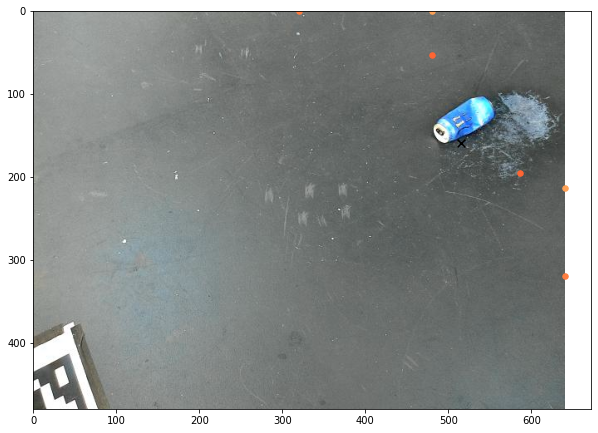

In [194]:
fig, ax = plt.subplots(1, 1, figsize = (10,8))
plotTreeOnImage(ax, tree, handColorImg)

In [192]:
moveRobotRelative(command_client, -0.5, 0.2, 0)

In [128]:
# vecAll = manipulation_api_pb2.VectorAlignmentWithTolerance(
#     axis_on_gripper_ewrt_gripper = geometry_pb2.Vec3(x = 1, y = 0, z = 0),
#     axis_to_align_with_ewrt_frame = geometry_pb2.Vec3(x = 0, y = 0, z = -1), 
#     threshold_radians = np.pi/4)

# allOr = manipulation_api_pb2.AllowableOrientation(vector_alignment_with_tolerance = vecAll)

# graspParams = manipulation_api_pb2.GraspParams(grasp_params_frame_name = 'vision',
#                                                allowable_orientation = [allOr], 
#                                                grasp_palm_to_fingertip = 0.8)

In [ ]:
# graspParams = manipulation_api_pb2.GraspParams(grasp_palm_to_fingertip = 0.0)

In [177]:
sqGrasp = manipulation_api_pb2.SqueezeGrasp(squeeze_grasp_disallowed = False)

allOr = manipulation_api_pb2.AllowableOrientation(squeeze_grasp = sqGrasp)

graspParams = manipulation_api_pb2.GraspParams(grasp_params_frame_name = 'vision',
                                               allowable_orientation = [allOr])

In [179]:
graspParams

grasp_params_frame_name: "vision"
allowable_orientation {
  squeeze_grasp {
  }
}

In [195]:
pxLoc = assemblePxTree(tree)
pick_vec = geometry_pb2.Vec2(x=pxLoc[0], y=pxLoc[1])

grasp = manipulation_api_pb2.PickObjectInImage(
    pixel_xy=pick_vec, transforms_snapshot_for_camera=image_response.shot.transforms_snapshot,
    frame_name_image_sensor=image_response.shot.frame_name_image_sensor,
    camera_model=image_response.source.pinhole)#, grasp_params = graspParams)

grasp_request = manipulation_api_pb2.ManipulationApiRequest(pick_object_in_image=grasp)



In [196]:
cmd = RobotCommandBuilder.arm_stow_command()
cmd_id = command_client.robot_command(cmd, end_time_secs = time.time()+5)

In [197]:
response, success = makeGrasp(grasp_request, graph_nav_client)

In [43]:
upload_graph_and_snapshots(graph_nav_client, upload_filepath)
response = graphLocalizeGuess(graph_nav_client, wp_loc_proto)

Loading the graph from disk into local storage...
Loaded graph has 27 waypoints and 29 edges
Uploading the graph and snapshots to the robot...


Upload complete! The robot is currently not localized to the map; please localize


In [198]:
randomCubeDrop(command_client)

In [122]:
nav_to_cmd_id = graph_nav_client.navigate_to(waypointDict[9], cmd_duration = 15)

In [46]:
cmd = RobotCommandBuilder.arm_stow_command()
cmd_id = command_client.robot_command(cmd, end_time_secs = time.time()+5)

In [45]:
nav_to_cmd_id = graph_nav_client.navigate_to(waypointDict[10], cmd_duration = 15)
waitUntilFinishedNav(nav_to_cmd_id)

In [44]:
nav_to_cmd_id = graph_nav_client.navigate_to(waypointDict[9], cmd_duration = 15)
waitUntilFinishedNav(nav_to_cmd_id)
moveRobotRelative(command_client, 0, 0, -np.pi/3)
moveToAndLookAt(command_client, [0.5, 0, 0.8], [0.7,0,0])
cmd = RobotCommandBuilder.claw_gripper_open_fraction_command(1.0)
cmd_id = command_client.robot_command(cmd, end_time_secs = time.time()+timeout_sec)

time.sleep(1)

In [170]:
handColorImg, image_response = capHandImage(image_client, 'hand_color_image')